In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import multivariate_normal
from sklearn.metrics import precision_recall_fscore_support as prfs
from sklearn.metrics import auc as auc
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import IsolationForest

In [2]:
df = pd.read_csv("creditcard.csv")
df.rename(columns={"Class": "target"}, inplace=True)

In [3]:
# General information (note, no missing values in original dataset)
sz = df.groupby("target").size()
n_pos = sz[1]
n_neg = sz[0]

print(f"Prop pos: {n_pos/(n_pos+n_neg)}") 
print(f"Num pos: {n_pos}")
print(f"Num neg: {n_neg}")
print(f"Size: ({df.shape[0]}, {df.shape[1]})")

Prop pos: 0.001727485630620034
Num pos: 492
Num neg: 284315
Size: (284807, 31)


In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,target
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
# Dataframe only sampling a fraction of negatives, to save computation time...
df_neg_sampled = df[df.target==0].sample(frac=0.05)
df_pos = df[df.target==1]
df_tsne_raw = df_neg_sampled.append(df_pos)

label = df_tsne_raw.iloc[:, -1]

In [6]:
# Scale data
scaler = StandardScaler()
#df_tsne = pd.DataFrame(scaler.fit_transform(df_tsne_raw.iloc[:, :-1]), columns = df_tsne_raw.iloc[:, :-1].columns)
data_tsne = scaler.fit_transform(df_tsne_raw.iloc[:, :-1])

In [7]:
tsne = TSNE(n_components=2, random_state=111)
data_tsne = tsne.fit_transform(data_tsne)

In [8]:
print(data_tsne.shape)
tsne_plot = np.vstack((data_tsne.T, label))
tsne_plot = tsne_plot.T
print(tsne_plot.shape)

(14708, 2)
(14708, 3)


c:\users\rnydestedt\miniconda3\envs\cs\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


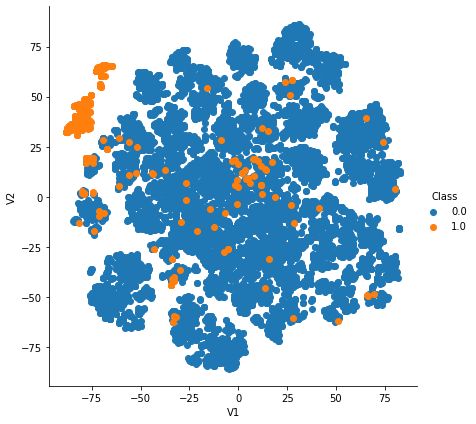

In [9]:
# Plots a pretty tsne plot, at least one big cluster and some that are not as defined for the positives
tsne_plot = pd.DataFrame(data=tsne_plot, columns=("V1", "V2", "Class"))
sb.FacetGrid(tsne_plot, size=6, hue="Class").map(plt.scatter, "V1", "V2").add_legend()

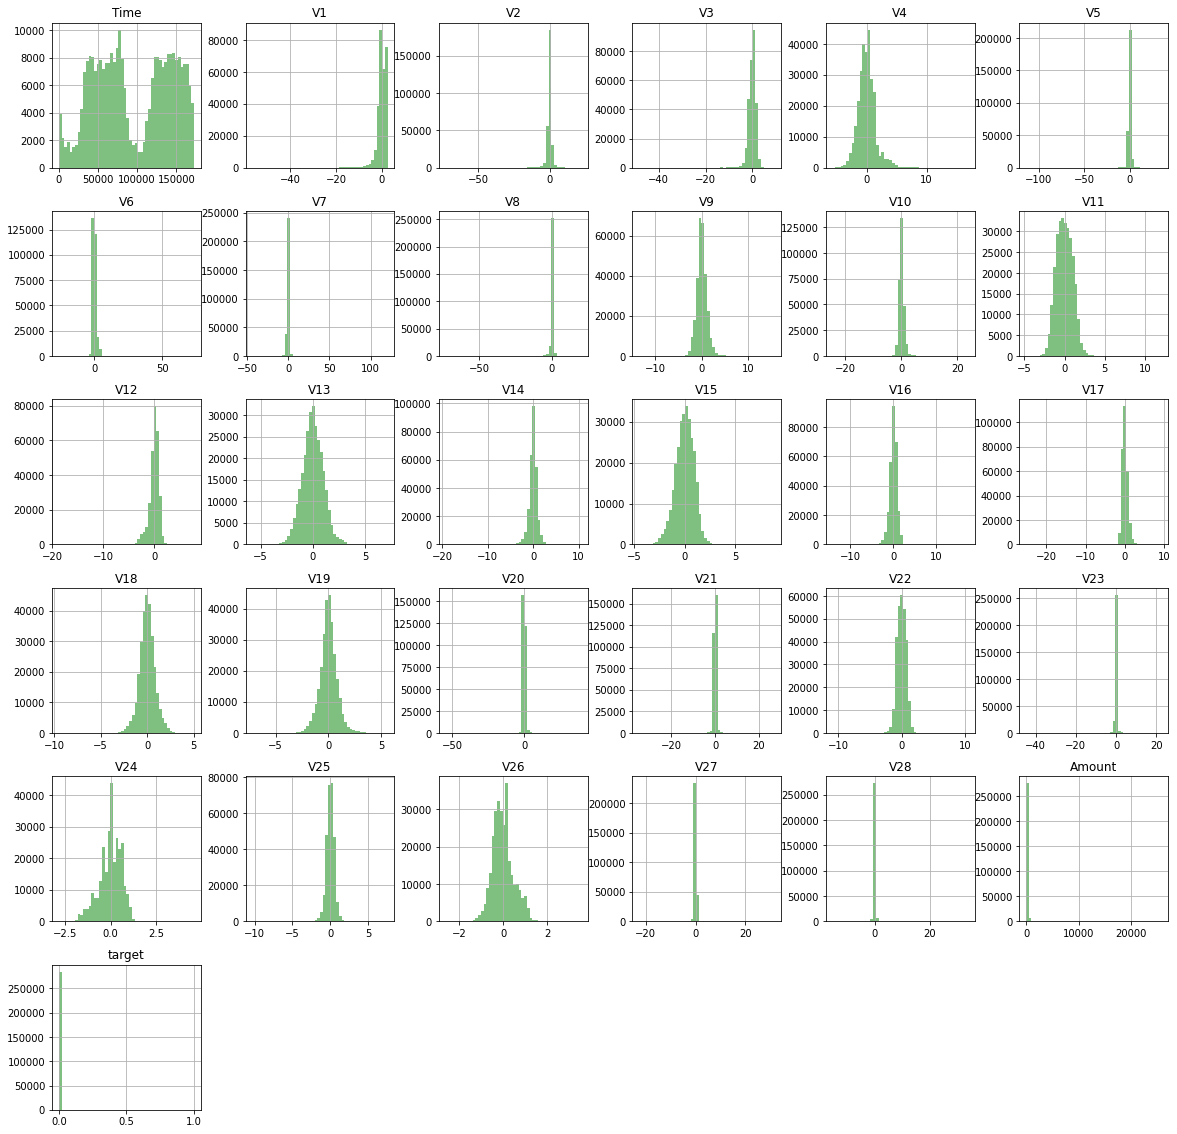

In [10]:
# Some distribution plots, other than Time most look normally distributed
df.hist(figsize=(20,20), bins=50, color="green", alpha=0.5)
plt.show()

In [263]:
# Split data, including fraud in train set
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size=0.2, random_state=1)


# Split data, but this time put all fraud in test set and only include normal in train

df_neg = df[df.target == 0]
df_pos = df[df.target == 1]



U_train = X_train[y_train == 0]
v_train = y_train[y_train == 0]
U_test = X_test.append(X_train[y_train == 1])
v_test = y_test.append(y_train[y_train == 1])
# Compute computation in test set
cntm = len(v_test[v_test==1])/len(v_test)

print(len(v_test[v_test==1]))
print(len(v_test[v_test==0]))

print(len(v_train[v_train==1]))
print(len(v_train[v_train==0]))
print(cntm)

492
56875
0
227440
0.008576359230916729


# Isolation Forest

In [264]:
# Not much param tuning done, likely performance to be had after a grid search....
mdl = IsolationForest(n_estimators = 100, max_samples=1000, random_state=1, contamination = n_pos/(n_pos+n_neg))
mdl.fit(X_train, y_train)

mdl2 = IsolationForest(n_estimators = 100, max_samples=1000, random_state=1, contamination = cntm)
mdl2.fit(X_train, y_train)

IsolationForest(contamination=0.008576359230916729, max_samples=1000,
                random_state=1)

In [265]:
y_score = pd.DataFrame(mdl.decision_function(X_test), columns=['dec_score'])

v_score = pd.DataFrame(mdl2.decision_function(U_test), columns=['dec_score'])

In [266]:
y_pred = pd.DataFrame(mdl.predict(X_test), columns=["pred"])
y_pred[y_pred['pred'] == 1] = 0
y_pred[y_pred['pred'] == -1] = 1

v_pred = pd.DataFrame(mdl.predict(U_test), columns=["pred"])
v_pred[v_pred['pred'] == 1] = 0
v_pred[v_pred['pred'] == -1] = 1

In [267]:
precision,recall,fbeta_score, support  = prfs(y_test, y_pred, average='binary')
print("precision ", round((precision), 4))
print("recall ", round((recall), 4))
print("F1 score on Test", round((fbeta_score), 4))

precision  0.3049
recall  0.2874
F1 score on Test 0.2959


In [268]:
precision,recall,fbeta_score, support  = prfs(v_test, v_pred, average='binary')
print("Positives only in test set:")
print("precision ", round((precision), 4))
print("recall ", round((recall), 4))
print("F1 score on Test", round((fbeta_score), 4))
# Notable improvement when excluding positives from train

Positives only in test set:
precision  0.7421
recall  0.3333
F1 score on Test 0.46


# Multivariate Gaussian

In [272]:
def multinorm(data):
    mean = np.mean(data, axis=0)
    cov = np.cov(data.T)
    return multivariate_normal(mean=mean, cov=cov)

# Using scaling (mean 0, std 1) to prevent singular cov matrices in multivariate_normal
# Scaled, training set includes frauds
# Also ropping Time, the one variable that's not at all normally distributed
X_tr_sc = scaler.fit_transform(X_train.drop(columns=["Time"]))
X_te_sc = scaler.fit_transform(X_test.drop(columns=["Time"]))
# Scaled, training frauds are moved to test
U_tr_sc = scaler.fit_transform(U_train.drop(columns=["Time"]))
U_te_sc = scaler.fit_transform(U_test.drop(columns=["Time"]))


mn_x = multinorm(X_tr_sc)
mn_u = multinorm(U_tr_sc)

In [273]:
print("Test pdf")
print(pd.DataFrame(mn_x.pdf(X_te_sc)).describe())
print("Train pdf")
print(pd.DataFrame(mn_x.pdf(X_tr_sc)).describe())

print("Test pdf, fraud moved to test")
print(pd.DataFrame(mn_u.pdf(U_te_sc)).describe())
print("Train pdf, fraud moved to test")
print(pd.DataFrame(mn_u.pdf(U_tr_sc)).describe())

Test pdf
                  0
count  5.696200e+04
mean   3.597680e-14
std    8.122370e-14
min    0.000000e+00
25%    1.795507e-17
50%    1.421357e-15
75%    2.599485e-14
max    1.010091e-12
Train pdf
                  0
count  2.278450e+05
mean   3.790755e-14
std    8.486276e-14
min    0.000000e+00
25%    2.182234e-17
50%    1.604838e-15
75%    2.796941e-14
max    1.100408e-12
Test pdf, fraud moved to test
                  0
count  5.736700e+04
mean   9.839448e-14
std    1.992929e-13
min    0.000000e+00
25%    1.591148e-16
50%    6.787430e-15
75%    8.995179e-14
max    2.211496e-12
Train pdf, fraud moved to test
                  0
count  2.274400e+05
mean   6.242457e-14
std    1.401013e-13
min    0.000000e+00
25%    3.535309e-17
50%    2.636906e-15
75%    4.561824e-14
max    1.813470e-12


In [316]:
def find_optimal_eps(probs, y_test, verbose=False):

    p = probs

    #epsilons = np.linspace(min(p), max(p), 1000)
    
    eps_opt = 0
    f1_opt = 0
    f1s = [None]*len(probs)
    for ind, eps in enumerate(np.sort(probs)):
        pred = p <= eps
        precision,recall,f1, support  = prfs(y_test, pred, average='binary')
        f1s[ind] = f1
        if f1 > f1_opt:
            f1_opt = f1
            eps_opt = eps
            recall_opt = recall
            precision_opt = precision
        
        if ind % 100 == 0 and verbose:
            print(f"{ind}) eps: {eps}, f1: {f1}, recall: {recall}, precision: {precision}")
        
        # If f1
        
        if recall == 1:
            print("Recall == 1, breaking.")
            break
        
        # This breaking condition is an eyesore,
        if ind > 1000 and f1s[ind] < max(f1s[ind-1000:ind-1]):
            print("f1 not improved in 400 iterations, breaking.")
            break
                
    print(f"Optimal eps: {eps_opt}, f1: {f1_opt}, recall: {recall_opt}, precision: {precision_opt}")
    return eps_opt, f1_opt, f1s

In [317]:
# Far better f1 score when excluding anomalies from training data, which is not really surprising. 
#For most cases having the cutoff slightly higher is likely preferred, as recall is quite low.
print("Incl. frauds in training data \n")
eps_x, f1_x, f1s_x = find_optimal_eps(mn_x.pdf(X_te_sc), y_test, True)
print("\n")
print("No frauds in training data \n")
eps_u, f1_u, f1s_u = find_optimal_eps(mn_u.pdf(U_te_sc), v_test, True)

Incl. frauds in training data 

0) eps: 0.0, f1: 0.2173913043478261, recall: 0.1724137931034483, precision: 0.29411764705882354
100) eps: 8.300426122303847e-205, f1: 0.1702127659574468, recall: 0.1839080459770115, precision: 0.15841584158415842
200) eps: 3.08078557270526e-117, f1: 0.19444444444444445, recall: 0.3218390804597701, precision: 0.13930348258706468
300) eps: 5.514768515292764e-91, f1: 0.18556701030927836, recall: 0.41379310344827586, precision: 0.11960132890365449
400) eps: 7.263507187471926e-76, f1: 0.1639344262295082, recall: 0.45977011494252873, precision: 0.09975062344139651
500) eps: 1.5045069292068913e-66, f1: 0.15306122448979592, recall: 0.5172413793103449, precision: 0.08982035928143713
600) eps: 6.936868412177213e-58, f1: 0.1453488372093023, recall: 0.5747126436781609, precision: 0.08319467554076539
700) eps: 6.757667283597123e-53, f1: 0.12690355329949238, recall: 0.5747126436781609, precision: 0.07132667617689016
800) eps: 2.471415630796528e-48, f1: 0.1148648648648

<ipython-input-346-914261552727>:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(probs[0:1000]), f1s_u[0:1000])


Text(0.5, 0, 'log(epsilon)')

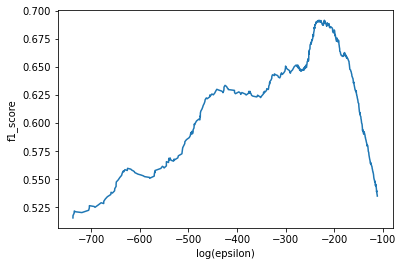

In [346]:
probs = np.sort(mn_u.pdf(U_te_sc))
plt.plot(np.log(probs[0:1000]), f1s_u[0:1000])
plt.ylabel("f1_score")
plt.xlabel("log(epsilon)")